# Comparison with Gaussian Random Field (Yu 2017) GRF

This notebooks compares the implementation of a Gaussian Random field when using a binary structure to the adapted IFTA presented in the main text.
We optimize for a Gaussian disk in the reciprocal space, instead of a constant ring in the main text. This is a limitation from the Gaussian Random Field deisgn, not from the IFTA.
The objective $Q$ is defined for a PSD with a Gaussian profile:

\begin{equation}
f(Q(k_g)) = \exp((-(k_g - \mu)^2/(2 \sigma ^2))
\end{equation}

We use an objetive reciprocal space of N=101 pixels. We also compare the contrast of the objective structures as the standard deviation of the error computed for each $k_x$, $k_y$.
\begin{equation}
\delta =  \sum_{i,j} ||Q_{i,j}| - |D^{s}_{i,j}|| / (N^2) \\
C =  \sigma(||Q_{i,j}| - |D^{s}_{i,j}||\\)
\end{equation}
[1] Yu, Shuangcheng, Chen Wang, Yichi Zhang, Biqin Dong, Zhen Jiang, Xiangfan Chen, Wei Chen, and Cheng Sun. “Design of Non-Deterministic Quasi-Random Nanophotonic Structures Using Fourier Space Representations.” Scientific Reports 7, no. 1 (June 16, 2017): 3752. https://doi.org/10.1038/s41598-017-04013-z.
[2] Ripoll, Olivier, Ville Kettunen, and Hans Peter Herzig. “Review of Iterative Fourier-Transform Algorithms for Beam Shaping Applications.” Optical Engineering 43, no. 11 (November 2004): 2549–2548. https://doi.org/10.1117/1.1804543.


In [70]:
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
np.set_printoptions(precision=4)

In [71]:
def create_objective(N, mu, sigma):
    """Create a Gaussian distribution for comparsion with the Gaussian Random Field"""
    x, y = np.meshgrid(np.arange(-N, N + 1), np.arange(-N, N + 1))
    R = np.sqrt(x**2 + y**2)
    mu = mu * N
    sigma = sigma * N
    I_G =  np.exp(-(R - mu)**2/(2*sigma **2 + 1e-19))#
    I_G[N,N] = 0 # we remove the 0 order always
    I_G = I_G/I_G.max()
    return I_G

## Gaussian Random Field functions

In [72]:
## Code for Gaussian Random Field taken from Andrew Walker implementation
##https://andrewwalker.github.io/statefultransitions/post/gaussian-fields
def fftIndgen(n):
    a = list(range(0, n//2+1))
    b = list(range(1, n//2))
    b = b[::-1]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 100,
                         seed=23):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    
    np.random.seed(seed)
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

## Adapted IFTA 

In [74]:
import IFTA as bidirect
# Implementation of the IFTA method [2],[3]

def create_doe(I, M=3, steps=200, seed=23, levels=2, **kwargs):
    """It creates a real space qr based on I as k-space,
    """
    # print(I.max(), I.min())
    if I.max() == I.min():
        Warning("No pattern found, skipping GSA")
        return I # constant return constant

    ntries = 5
    if M==0:
        method= bidirect.GSA_A
    else:
        method = bidirect.WA_A
    while ntries >0:
        try:
            F_WA, I_WA, error_WA = method(I, M=M, steps=steps, levels=levels, 
                                          seed=seed)
            ntries = 0
        except ValueError:
            print('Error with the seed, adding {} and trying again'.format(ntries))
            # F_WA, I_WA, error_WA = bidirect.WA(I, M=M, steps=steps, levels=levels, 
                                          # seed=seed + ntries)
            ntries = ntries - 1
            seed = seed + ntries

    F_WA = F_WA/np.pi
    # DOE = dict(F=F_WA,I=I_WA,error=error_WA)
    return F_WA, error_WA


In [75]:
### Dictionary for storing the results
data_results = {}

Objective, Result, QR


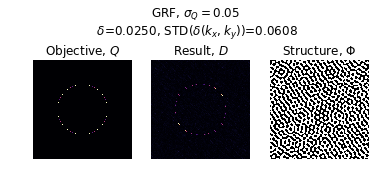

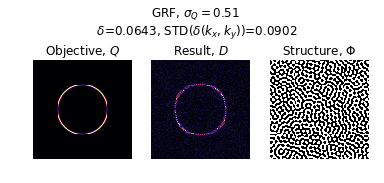

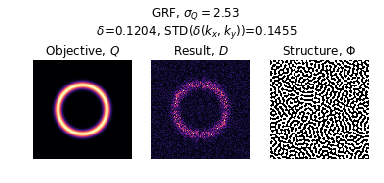

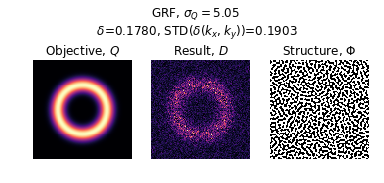

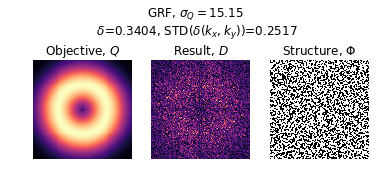

In [119]:
delta = np.zeros(5)
std_delta = np.zeros(5)

s = 101 # Number of pixels
dalpha = 0.5 # The relative position of the Max. normalize to 1
dsigmas = np.array([0.001, 0.01, 0.05, 0.1, 0.3])
alpha = s/2 * dalpha
sigmas = s/2 * dsigmas

Method="GRF"
print("Objective, Result, QR")
for i, dsigma in enumerate(dsigmas): 
    sigma = sigmas[i]
    obj = create_objective(s//2, dalpha, dsigma)
    Pk = lambda k: np.exp(-(k - alpha) **2 / (2 * sigma**2 ))
    out = gaussian_random_field(Pk = Pk, size=s)
    out = out.real
    out = out + abs(out.min()) # move everything to positives
    
    #binarization
    out = abs(out)/abs(out).max()
    threshold = 0.5
    out[out < threshold] = 0
    out[out >= threshold] = 1
    result =  np.fft.fftshift(abs(np.fft.fft2(out.real))).real
    result[s//2,s//2]=0 # Suppresing ZDO
    
    #comparing
    diff = abs(obj-result/result.max())
    contrast = diff.std()
    error = diff.mean()
     
    #storing 
    delta[i] =  error
    std_delta[i] = contrast
     
    
    ## Plotting
    fg, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
    axes[0].imshow(obj, interpolation='none', cmap = 'magma')
    axes[1].imshow(result, interpolation='none', cmap='magma')
    axes[2].imshow(out.real, interpolation='none', cmap='binary')
    
    
    axes[0].set_title('Objective, $Q$')
    axes[1].set_title('Result, $D$')
    axes[2].set_title('Structure, $\Phi$')
    [ax.axis('off') for ax in axes]
    fg.suptitle('{1}, $\sigma_Q=${2:.2f}\n $\delta$={0:.4f}, '.format(error,Method,sigma) + 
                'STD($\delta(k_x,k_y)$)={0:.4f}'.format(contrast))
    #fg.tight_layout()
    if i==2:
        fg.savefig(f"{Method}_{sigma:.2f}.pdf", dpi=600)
        fg.savefig(f"{Method}_{sigma:.2f}.svg", dpi=600)
        
    
## Storing data
data_results[Method] = {"sigmas":sigmas, "error":delta, "contrast":std_delta} 

### IFTA

Objective, Result, QR


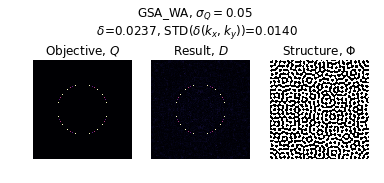

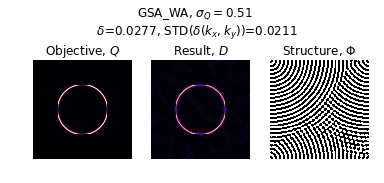

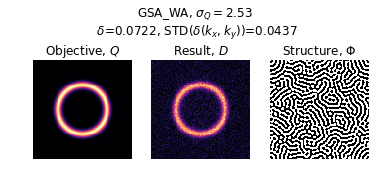

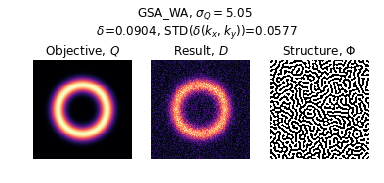

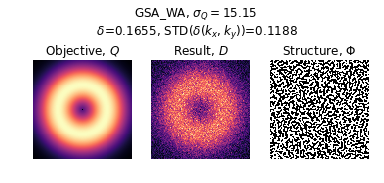

In [120]:
delta = np.zeros(5)
std_delta = np.zeros(5)

s = 101 # Number of pixels
dalpha = 0.5 # The relative position of the Max. normalize to 1
dsigmas = np.array([0.001, 0.01, 0.05, 0.1, 0.3])
alpha = s/2 * dalpha
sigmas = s/2 * dsigmas

Method="GSA_WA"
print("Objective, Result, QR")
for i, dsigma in enumerate(dsigmas):
    sigma = sigmas[i]
    obj= create_objective(s//2, dalpha, dsigma)
    out, error = create_doe(obj, M=1, steps=200) #M>0 adds a window and the first  
    result =  np.fft.fftshift(abs(np.fft.fft2(out.real)))
    result[result.shape[0]//2,result.shape[1]//2]=0
    result = result/result.max()
    
    #rescale to the window of the WA_GSA
    sN = obj.shape[0]
    MN = (result.shape[0] - 1 )//2
    win2 = [(result.shape[0] - obj.shape[0])//2,
            (result.shape[0] - obj.shape[0])//2 + obj.shape[0]]

    # comparing
    resultw = result[win2[0]:win2[1], win2[0]:win2[1]]
    diff = abs(obj-resultw/resultw.max())
    contrast = diff.std() 
    error = diff.mean() 
    
    #storing
    delta[i] =  error 
    std_delta[i] = contrast
    
    #plotting
    fg, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,3))
    axes[0].imshow(obj, interpolation='none', cmap='magma')
    axes[1].imshow(resultw, interpolation='none', cmap='magma')
    axes[2].imshow(out.real, interpolation='none', cmap='binary')
    
    
    axes[0].set_title('Objective, $Q$')
    axes[1].set_title('Result, $D$')
    axes[2].set_title('Structure, $\Phi$')
    [ax.axis('off') for ax in axes]
    fg.suptitle('{1}, $\sigma_Q=${2:.2f}\n $\delta$={0:.4f}, '.format(error,Method,sigma) + 
                'STD($\delta(k_x,k_y)$)={0:.4f}'.format(contrast))
    #fg.tight_layout()
    
    if i==2:
        fg.savefig(f"{Method}_{sigma:.2f}.pdf", dpi=600)
        fg.savefig(f"{Method}_{sigma:.2f}.svg", dpi=600)
    
## Storing data
data_results[Method] = {"sigmas":sigmas, "error":delta, "contrast":std_delta} 

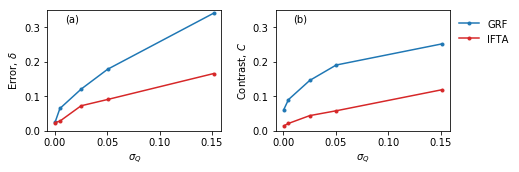

In [122]:
fg, ax = plt.subplots(1,2, figsize=(6.5, 2.5), );
ax[0].plot(data_results["GRF"]["sigmas"]/100, data_results["GRF"]["error"],'.-')
ax[0].plot(data_results["GSA_WA"]["sigmas"]/100, data_results["GSA_WA"]["error"],'.-', color='C3')

ax[1].plot(data_results["GRF"]["sigmas"]/100, data_results["GRF"]["contrast"], '.-', label="GRF")
ax[1].plot(data_results["GSA_WA"]["sigmas"]/100, data_results["GSA_WA"]["contrast"],'.-', label="IFTA", color='C3')

ax[0].set_xlabel('$\sigma_Q$')
ax[1].set_xlabel('$\sigma_Q$')
ax[0].set_ylabel('Error, $\delta$')
ax[1].set_ylabel('Contrast, $C$')
ax[0].set_ylim(0,0.35)
ax[1].set_ylim(0,0.35)
ax[0].text(0.1,0.9, "(a)", transform=ax[0].transAxes)
ax[1].text(0.1,0.9, "(b)", transform=ax[1].transAxes)
fg.tight_layout()
ax[1].legend(loc=2,bbox_to_anchor=(1,1),frameon=False)
fg.savefig("../../reports/apl_paper0_suppl/Suppl.Figures/ErrorGRFvsIFTA.pdf", bbox_inches="tight", dpi=600)
#fg.savefig("Comparison Methods for a Gaussian Objective.svg", bbox_inches="tight", dpi=600)

(a) Comparison of the error in % for the the Gaussian Random Field, and the IFTA for increasing sigma.
(a) Comparison of the contrast in % for the the Gaussian Random Field, and the IFTA for increasing sigma.

## Appendix: Example GRF No binarization

35.0
25.0
10.0


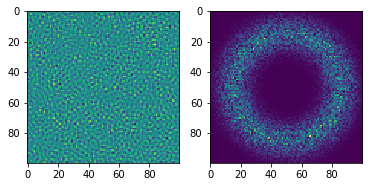

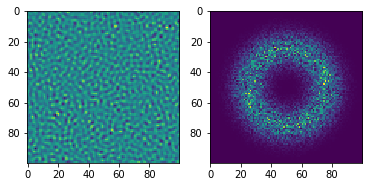

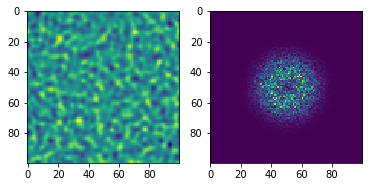

In [83]:
for dalpha in [0.7, 0.5, 0.2]:
    s = 100
    alpha = s / 2 * dalpha
    print(alpha)
    dsigma = 0.05
    sigma = s * dsigma
    Pk = lambda k: np.exp(-(k-alpha)**2/(2*sigma **2))
    out = gaussian_random_field(Pk = Pk, size=s)
#    out = abs(out)/abs(out).max()
#    threshold = 0.5
#    out[out < threshold] = 0
#    out[out >= threshold] = 1
    obj =  np.fft.fftshift(abs(np.fft.fft2(out.real)))
    obj[s//2,s//2]=0
    fg, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(out.real, interpolation='none')
    axes[1].imshow(obj, interpolation='none')